<div style="width: 100%; clear: both; font-family: Verdana;">
<div style="float: left; width: 50%;font-family: Verdana;">
<img src="https://github.com/Eligoze/att-rci-internal/blob/qa/RCI_DataAnalysis/eda/doc/att-logo1.png" align="left">
</div>
<div style="float: right; width: 200%;">
<p style="margin: 0; padding-top: 20px; text-align:right;color:rgb(193, 38, 184)"><strong>Axity - AT&T.
    Ciclo de vida de elementos de inventario</strong></p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Exploratory Data Analysis
## Ciclo de vida de elementos de inventario.
### Axity - AT&T.

## Descripción
Analizaremos los datos de las fuentes de inventarios de AT&T con un tratamiento estadístico descriptivo para hacer el tracking del ciclo de vida de los elementos de red. Se creará un EDA enfocado a la salida de almacén. Serán documentados los catálogos propuestos junto a su respectivo tratamiento de datos. La fuente que corresponde a este análisis es:

* **Gestor Blaulabs**

Primero cargamos las librerías necesarias.

#### Conectando al Datalake

In [9]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

In [10]:
conf = SparkConf().setAppName('Segregacion')  \
    .setMaster('yarn').set("spark.yarn.queue","root.eda")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import fuzzywuzzy
from fuzzywuzzy import process, fuzz

from pyspark.sql.functions import udf ,col
from pyspark.sql.types import IntegerType,StringType

%matplotlib inline

from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20c_11,Category20c_13, Category20c_20, Category10_5,Category10_6, Category20_20, Plasma256
output_notebook()

Loading BokehJS ...

### 1.1 Recolección de los datos: 

*IMPORTANTE*: Si se requieren ver datos de otro periódo, se debe cambiar los filtros ```year = <año-a-ejecutar>```, ```month = <mes-a-ejecutar>```, ```day = <día-a-ejecutar>``` de las tablas en la siguiente celda:

In [12]:
# reglas para serie con pyspark
#sobre el df que se carga con pysaprk, se le agrega una columna 
#con el nombre de serie_cleaned. el cual contiene valores 0 y 1 

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se crea el dataframe de spark
    </p>
</div>

In [13]:
df_load1=spark.sql("SELECT * FROM tx_bl_inventarione").cache()#.toPandas() 

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Creamos una funcion para el tratamiento de datos en spark el cual contiene la reglas definidas para la columna serie:
    </p>
</div>

In [14]:
def validate_rule(string):
    
    search_list=[" ",'!','%','$',"<",">","^",'¡',"+","N/A",u'¿','~','#','Ñ',"Ã","Åƒ","Ã‹","Ã³",'Ë','*','?',"ILEGIBLE", "VICIBLE","VISIBLE","INCOMPLETO"]
    str_temp = string.encode('utf-8')
    if str_temp.upper() == "BORRADO":
      return 1
    elif len(str_temp) < 6:
      return 1
    elif any(ext in str_temp.upper()for ext in search_list):
      return 1
    else:
      return 0

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se crea un udf en spark sobre la funcion ya creada 
    </p>
</div>

In [15]:
validate_rule_udf = udf(validate_rule, IntegerType())

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se le agrega una nueva columna al dataframe de spark; la nueva columna es la validacion de la columna serie con respecto al udf que creamos.
    </p>
</div>

In [16]:
df_serie1 = df_load1.withColumn("serie_cleaned",validate_rule_udf(col("serie"))).cache()

<div style="width: 100%; clear: both; font-family: Verdana;">
    <p> 
    Se convierte el dataframe de spark a un dataframe de pandas 
    </p>
</div>

In [17]:
df_ne = df_serie1.toPandas()

Hemos recolectado los campos a analizar de la fuente **Blaulabs_NE**.

## Gestor: Blaulabs
Una muestra de la fuente **Blaulabs_NE**

In [18]:
df_ne.head(5)

,region,mso,sala,pasillo,rack,elemento,tipo,marca,modelo,serie,...,hash_id,sourceid,registry_state,datasetname,timestamp,transaction_status,year,month,day,serie_cleaned
0,Region 1,Otay,Sala pop evolution telcos 3,Fila 1,Rack 001,C406-0978,NE,ACCEDIAN,LT,C406-0978,...,c46a939ab0324df2a3679229ad42e276670ae323858024...,InventarioEM,2019:101:28:23:35:22,bl_inventario,20191129,insert,2019,8,7,0
1,Region 1,Otay,Sala pop evolution telcos 3,Fila 1,Rack 001,ODF FRONTERAODF 30,NE,PANDUIT,OPTICOM,NE,...,c52f0c516c831581ea9b1163490e4676036eab9b02dd9c...,InventarioEM,2019:101:28:23:35:22,bl_inventario,20191129,insert,2019,8,7,1
2,Region 1,Otay,Sala pop evolution telcos 3,Fila 1,Rack 001,ODF LADO A,NE,PANDUIT,OPTICOM,NE,...,c52f0c516c831581ea9b1163490e4676036eab9b02dd9c...,InventarioEM,2019:101:28:23:35:22,bl_inventario,20191129,insert,2019,8,7,1
3,Region 1,Otay,Sala pop evolution telcos 3,Fila 1,Rack 001,ODF LADO B,NE,PANDUIT,OPTICOM,NE,...,c52f0c516c831581ea9b1163490e4676036eab9b02dd9c...,InventarioEM,2019:101:28:23:35:22,bl_inventario,20191129,insert,2019,8,7,1
4,Region 1,Otay,Sala pop evolution telcos 3,Fila 1,Rack 001,TIJ-MTY,NE,ACCEDIAN,METRONID,NE,...,d1db8d095e18cede2016e5e360269f0c98cde8d6a21daa...,InventarioEM,2019:101:28:23:35:22,bl_inventario,20191129,insert,2019,8,7,1


### Diccionario de datos.
A continuación se enlistan los campos de la fuente con una breve descripción de negocio.  

* **region**: Región en donde se encuentra el elemento.
* **mso**: Oficina ATT.
* **sala**: Pendiente.
* **pasillo**: Pendiente.
* **rack**: Número de Rack.
* **elemento**: Nombre del elemento.
* **tipo**: Pendiente. *Podría ser nombre del dataset*
* **marca**: Marca.
* **modelo**: Modelo.
* **serie**: Código de trazabilidad que da el proveedor.
* **serie_cleaned**: Campo colocado en proceso Spark. Es una bandera que revisa la consistencia de la serie.
* **filedate**: Fecha de carga del archivo.
* **filename**: Nombre del archivo cargado.
* **hash_id**: Identificador único Hash.
* **source_id**: Fuente de archivo.
* **registry_state**: Timestamp de carga.
* **datasetname**: Nombre del ....
* **timestamp**: Fecha de carga.
* **transaction_status**: Estatus de carga.
* **year**: Año del archivo.
* **month**: Mes del archivo.
* **day**: Día del archivo.

### 1.2 Recolección de los datos:

In [19]:
df_load2=spark.sql("SELECT * FROM tx_bl_inventarioem").cache()#.toPandas()

In [20]:
df_serie2 = df_load2.withColumn("serie_cleaned",validate_rule_udf(col("serie"))).cache()

In [21]:
df_em = df_serie2.toPandas()

Hemos recolectado los campos a analizar de la fuente **Blaulabs_EM**.

#### Una visualización de la fuente **Blaulabs_EM**: 

In [22]:
df_em.head()

,region,mso,sala,elemento,descripcion,capacidad,tipo,plataforma,marca,modelo,...,hash_id,sourceid,registry_state,datasetname,timestamp,transaction_status,year,month,day,serie_cleaned
0,Region 3,Ciudad Juárez,Sala Switch,MSOJUA01-PDF02,Ciudad Juárez-Sala Switch-MSOJUA01-PDF02,800 Amp,EM,PDF,GE,H569445,...,7e543bc0819aca2e378e4ce8458d6ab5191a22a3bc9980...,InventarioEM,2019:101:28:21:39:20,bl_inventario,20191129,update,2019,9,10,0
1,Region 1,Otay,Sala DC 3G,MSOTIJ01-INV02,Otay-Sala DC 3G-MSOTIJ01-INV02,,EM,Inversor,MGE UPS SYSTEM,NE,...,07043227d78a2bef90431bd4cbf7a797c83639ac037f57...,InventarioEM,2019:101:28:21:39:20,bl_inventario,20191129,delete,2019,9,10,0
2,Region 3,Ciudad Juárez,Sala Switch,MSOJUA01-PDB03,Ciudad Juárez-Sala Switch-MSOJUA01-PDB03,300 Amp,EM,PDB,GE,ED83368-30 G4,...,01d16e28d6038a4a3c4fbbc8f535033498c94e1ee912fc...,InventarioEM,2019:101:28:21:39:20,bl_inventario,20191129,delete,2019,9,10,1
3,Region 9,Megacentro,Sala Verde,MSOMEX1-PDUB104.03,Megacentro-Sala Verde-MSOMEX1-PDUB104.03,,EM,PDU,CPI,NE,...,4fc37bba98258df58076bcbc7b76696c5df2bb84dc3ca8...,InventarioEM,2019:101:28:21:39:20,bl_inventario,20191129,update,2019,9,10,1
4,Region 1,Otay,Sala Telco 1 Evolution,MSOTIJ01-TEL1E-ST-01,Otay-Sala Telco 1 Evolution-MSOTIJ01-TEL1E-ST-01,,EM,Temperatura,ENDRESS+HAUSER,TST434-J1B3D4,...,3363b47ce00815319662872254811c6ddd238efa31a910...,InventarioEM,2019:101:28:21:39:20,bl_inventario,20191129,insert,2019,9,10,0


### Diccionario de datos.
A continuación se enlistan los campos de la fuente con una breve descripción de negocio.  

* **region**: Región en donde se encuentra el elemento.
* **mso**: Oficina ATT.
* **sala**: Pendiente.
* **elemento**: Nombre del elemento.
* **descripcion**: Pendiente.
* **capacidad**: Capacidad de la antena.
* **tipo**: Pendiente. *Podría ser nombre del dataset*
* **plataforma**: Pendiente.
* **marca**: Marca.
* **modelo**: Modelo.
* **serie**: Código de trazabilidad que da el proveedor.
* **activofijo**: Código de trazabilidad que da el proveedor.
* **serie_cleaned**: Campo colocado en proceso Spark. Es una bandera que revisa la consistencia de la serie.
* **filedate**: Fecha de carga del archivo.
* **filename**: Nombre del archivo cargado.
* **hash_id**: Identificador único Hash.
* **source_id**: Fuente de archivo.
* **registry_state**: Timestamp de carga.
* **datasetname**: Nombre del ....
* **timestamp**: Fecha de carga.
* **transaction_status**: Estatus de carga.
* **year**: Año del archivo.
* **month**: Mes del archivo.
* **day**: Día del archivo.

### 2.1 Descripción de las fuentes.
En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [23]:
campos=df_ne.columns
print 'Columnas de la fuente Blaulabs_NE son: ',list(campos)
pd.DataFrame(df_ne.dtypes,columns=['Tipo de objeto Blaulabs_NE'])

Columnas de la fuente Blaulabs_NE son:  ['region', 'mso', 'sala', 'pasillo', 'rack', 'elemento', 'tipo', 'marca', 'modelo', 'serie', 'filedate', 'filename', 'hash_id', 'sourceid', 'registry_state', 'datasetname', 'timestamp', 'transaction_status', 'year', 'month', 'day', 'serie_cleaned']


,Tipo de objeto Blaulabs_NE
region,object
mso,object
sala,object
pasillo,object
rack,object
elemento,object
tipo,object
marca,object
modelo,object
serie,object


In [24]:
print 'renglones = ',df_ne.shape[0],' columnas = ',df_ne.shape[1]

renglones =  6678  columnas =  22


In [25]:
#Pasamos las columnas que queremos ver en nuestro describe:
NOrelevantes=['filedate', 'filename', 'hash_id', 'sourceid',
              'registry_state', 'datasetname', 'timestamp',
              'transaction_status', 'year', 'month', 'day']
relevantes_ne=[v for v in df_ne.columns if v not in NOrelevantes]

df_ne[relevantes_ne].describe(include='all')

,region,mso,sala,pasillo,rack,elemento,tipo,marca,modelo,serie,serie_cleaned
count,6678,6678,6678,6678,6678,6678,6678,6678,6678,6678,6678.000000
unique,7,13,35,60,965,5034,1,286,1209,1428,NaN
top,Region 9,Megacentro,Sala core,Fila 103,Rack 104.05,PDU,NE,HUBBELL,NEXTFRAME,NE,NaN
freq,2490,1367,988,789,64,129,6678,1429,336,5129,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.815514
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387909
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


#### Haremos anotaciones sobre lo que se puede observar de la tabla describe:

* Según lo observado en los uniques de la tabla describe, podrían proponerse para catálogos los campos **region, mso, marca** y **modelo**.
* No hay variables continuas.
* Hay muchos valores *NE* en el campo **serie**, estos serán tratados como data errors y marcados como nulos.

#### Se proponen catálogos derivados de la fuente Blaulabs_NE con los siguientes campos:
    
* **region**: Región en donde se encuentra el elemento.
* **mso**: Oficina ATT.  
* **marca**: Marca.  
* **modelo**: Modelo.    

Estos catálogos nos ayudarán a mapear todos los diferentes proyectos que existen en los cuales hay un activo.


### 2.2 Descripción de las fuentes.

#### Continuamos con Blaulabs_EM

In [26]:
campos=df_em.columns
print 'Columnas de la fuente Blaulabs_EM son: ',list(campos)
pd.DataFrame(df_em.dtypes,columns=['Tipo de objeto Blaulabs_EM'])

Columnas de la fuente Blaulabs_EM son:  ['region', 'mso', 'sala', 'elemento', 'descripcion', 'capacidad', 'tipo', 'plataforma', 'marca', 'modelo', 'serie', 'activofijo', 'filedate', 'filename', 'hash_id', 'sourceid', 'registry_state', 'datasetname', 'timestamp', 'transaction_status', 'year', 'month', 'day', 'serie_cleaned']


,Tipo de objeto Blaulabs_EM
region,object
mso,object
sala,object
elemento,object
descripcion,object
capacidad,object
tipo,object
plataforma,object
marca,object
modelo,object


In [27]:
print 'renglones = ',df_em.shape[0],' columnas = ',df_em.shape[1]

renglones =  2830  columnas =  24


In [28]:
#Pasamos las columnas que queremos ver en nuestro describe:
NOrelevantes=['filedate', 'filename', 'hash_id', 'sourceid',
              'registry_state', 'datasetname', 'timestamp',
              'transaction_status', 'year', 'month', 'day']
relevantes_em=[v for v in df_em.columns if v not in NOrelevantes]

df_em[relevantes_em].describe(include='all')

,region,mso,sala,elemento,descripcion,capacidad,tipo,plataforma,marca,modelo,serie,activofijo,serie_cleaned
count,2830,2830,2830,2830,2830,2830,2830,2830,2830,2830,2830,2830,2830.000000
unique,12,19,138,1612,1669,108,2,18,102,237,978,730,NaN
top,Region 9,Megacentro,Sala Switch,MSOTIJ01-PDF109.00,,,EM,PDU,ENDRESS+HAUSER,TST434-J1B3D4,NE,NE,NaN
freq,677,742,253,6,6,1690,2828,500,866,808,978,854,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378799
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485174
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


#### Haremos anotaciones sobre lo que se puede observar de la tabla describe:

* Según lo observado en los uniques de la tabla describe, podrían proponerse para catálogos los campos **region, mso, marca** y **modelo**. Estos serán corroborados usando los que se proponen en Blaulabs_NE
* No hay variables continuas.
* Hay muchos valores *NE* en los campos **serie** y **activofijo**, estos serán tratados como data errors y marcados como nulos.
* En el campo **capacidad** hay nulos no mapeados.

#### Se proponen catálogos derivados de la fuente Blaulabs_EM con los siguientes campos:
    
* **region**: Región en donde se encuentra el elemento.
* **mso**: Oficina ATT.  
* **marca**: Marca.  
* **modelo**: Modelo.    

Estos catálogos nos ayudarán a mapear todos los diferentes proyectos que existen en los cuales hay un activo.

### 3.1 Exploración de los datos.
De acuerdo al análisis anterior, procedemos a hacer una exploración de los datos con gráficas, de manera particular nos enfocaremos en los catálogos.  
Se empezará analizando el source **Blaulabs_NE**.

#### Para empezar, se hará una limpieza general a los datos:

In [29]:
df_ne.replace('null',np.NaN,inplace=True)
df_ne.replace('NA',np.NaN,inplace=True)
df_ne.replace('',np.NaN,inplace=True)
df_ne.replace('NE',np.NaN,inplace=True)
#Se puede hacer más y por columna en caso de ser necesario

### Primer catálogo: *region*

Empezaremos con el catálogo de region. Según lo apreciado en el describe, este campo se encuentra limpio, se harán visualizaciones para corroborar, ver las distintas categorías y sus frecuencias. Este catálogo será llamado después en el apartado de catálogos. Nuestra intención por el momento es simplemente explorar los datos.

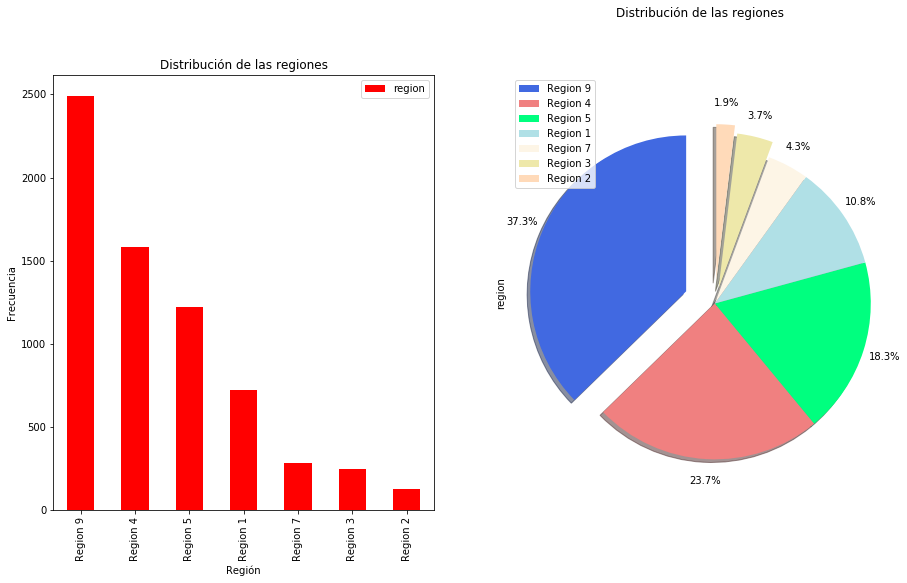

In [30]:
#Revisamos frecuencias:
region=pd.DataFrame(df_ne.region.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
region.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'Región')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Distribución de las regiones')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
explode_list=[.2,0,0,0,0,0.1,0.15] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid','turquoise','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','powderblue']

region['region'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Distribución de las regiones',y=1.12)
ax1.axis('equal')
ax1.legend(labels=region.index,loc='upper left')

plt.show()

Como se esperaba, es un catálogo limpio, pero se observa que faltan categorías. Se espera poder encontrar más con la fuente *Blaulabs_EM*.  
Se podrá encontrar el catálogo en el apartado **Catálogos**.

#### Segundo catálogo: *mso*

In [31]:
len(df_ne.mso.value_counts())

13

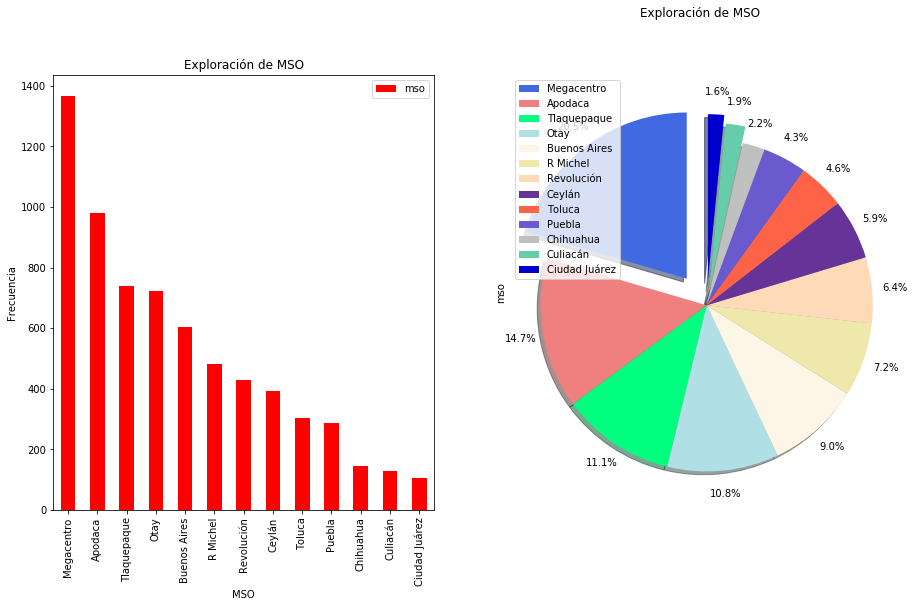

In [32]:
#Revisamos frecuencias:
mso=pd.DataFrame(df_ne.mso.value_counts())

#Visualización:
fig=plt.figure()
ax0=fig.add_subplot(1,2,1)
ax1=fig.add_subplot(1,2,2)

#Subplot1: Bar chart
mso.plot(kind='bar',figsize=(10,6),colormap='rainbow_r',ax=ax0)
ax0.set_xlabel(u'MSO')
ax0.set_ylabel('Frecuencia')
ax0.set_title(u'Exploración de MSO')

#Subplot2: Pie chart
#La lista explode debe ser ajustada manualmente contra el número de elementos del catálogo
explode_list=[.2,0,0,0,0,0,0,0,0,0,0,0.1,0.15] #Cada entrada corresponde a un registro del catálogo

color_list=['royalblue','lightcoral','springgreen','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','silver','mediumaquamarine',
            'mediumblue','mediumorchid','turquoise','powderblue','oldlace','palegoldenrod',
            'peachpuff','rebeccapurple','tomato','slateblue','powderblue']

mso['mso'].plot(kind='pie',         
                    figsize=(15,8),
                    autopct='%1.1f%%',
                    startangle=90,
                    shadow=True,
                    labels=None,
                    pctdistance=1.14,
                    colors=color_list,
                               ax=ax1,
                    explode=explode_list)
ax1.set_title(u'Exploración de MSO',y=1.12)
ax1.axis('equal')
ax1.legend(labels=mso.index,loc='upper left')

plt.show()

Se tiene un campo limpio, se podrá encontrar el catálogo en el apartado **Catálogos**.

#### Tercer catálogo: *marca* .

In [33]:
pd.DataFrame(df_ne.marca.value_counts()[:45])

,marca
HUBBELL,1429
HUAWEI,980
CISCO,759
ADC,596
HP,386
DELL,202
TELLABS,159
PANDUIT,147
HPE,124
Cisco Systems Inc,110


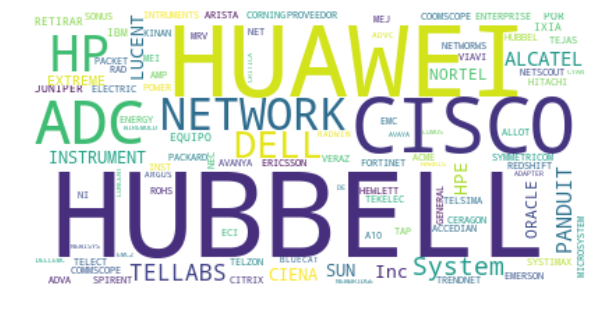

In [34]:
aux=pd.DataFrame(df_ne.marca)
aux.columns=['marca']
aux.dropna(inplace=True)
marcas=list(aux.marca)
marcas=(" ").join(marcas)
marca_wordcloud=WordCloud(background_color='white',max_words=100,collocations=False,stopwords=None).generate(marcas)

plt.figure(figsize=(10,7))
plt.imshow(marca_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Observamos que hace falta un poco de limpieza. Hay marcas que difieren como *CISCO* y *Cisco Systems Inc*.  
Encontramos también la presencia de *HPE* y *HP*. Hay múltiples casos en los que se tendría que definir con negocio si son marcas distintas o son la misma. 

#### Cuarto catálogo: modelo

In [35]:
pd.DataFrame(df_ne.modelo.value_counts())

,modelo
NEXTFRAME,336
NEXT FRAME,252
CAT 6,239
CAT6,221
UCS C240 M4,185
NEXTSPEED6,147
PARC,114
NEXTSPEED 6,102
TRUENET,99
PAN-NET,93


In [36]:
print 'El campo actualmente tiene: ',df_ne.modelo.unique().shape[0],' Registros unicos'

El campo actualmente tiene:  1207  Registros unicos


#### Observamos que este es un campo con muy mala calidad.
Se hacen reglas de limpieza:

In [37]:
aux=pd.DataFrame(df_ne.modelo)
aux.columns=['modelo']
aux.replace(' ','',regex=True,inplace=True)
aux.replace('NEXTSPPED6','NEXTSPEED6',regex=True,inplace=True)
aux.modelo.str.strip()
aux.drop_duplicates(inplace=True)
print'Se han reducido los unicos a: ',aux.shape[0]
aux.head()

Se han reducido los unicos a:  1108


,modelo
0,LT
1,OPTICOM
4,METRONID
6,NEXTSPEED6
13,SUPERVISERYMODULOSM32


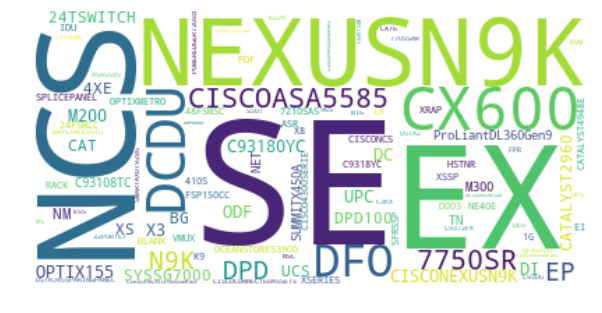

In [38]:
aux.dropna(inplace=True)
modelo=list(aux.modelo)
modelo=(" ").join(modelo)
modelo_wordcloud=WordCloud(background_color='white',max_words=100,collocations=False,stopwords=None).generate(modelo)

plt.figure(figsize=(10,7))
plt.imshow(modelo_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Para este campo, se tomará como referencia el catálogo que nos ha proveído AT&T.  
Podremos encontrarlo en el apartado **Catálogos**.

#### Visualización de los datos de trazabilidad: 

In [39]:
pd.DataFrame(df_ne.serie.value_counts()[:15])

,serie
EQUIPO POR RETIRAR,36
PROVEEDOR (IT),10
CX600 SERIES,7
SG7000,3
8290,3
8280,3
605365610906000000,3
QUIDWAY CX600 SERIES,3
S5352C-E1,2
NTJS63,2


Encontramos un problema muy grave de calidad en el campo **serie**.

### 3.2 Exploración de los datos.
Para el caso del source **Blaulabs_EM** se corroborarán los campos contra los analizados anteriormente.

#### Para empezar, se hará una limpieza general a los datos:

In [40]:
df_em.replace('null',np.NaN,inplace=True)
df_em.replace('NA',np.NaN,inplace=True)
df_em.replace('',np.NaN,inplace=True)
df_em.replace('NE',np.NaN,inplace=True)
#Se puede hacer más y por columna en caso de ser necesario

### Primer catálogo: *region*

Empezaremos con el catálogo de region. Según lo apreciado en el describe, este campo se encuentra limpio, se harán visualizaciones para corroborar, ver las distintas categorías y sus frecuencias. Este catálogo será llamado después en el apartado de catálogos. Nuestra intención por el momento es simplemente explorar los datos.

In [41]:
pd.DataFrame(df_em.region.value_counts().keys(),columns=['Regiones']).sort_values(by='Regiones')

,Regiones
2,Region 1
9,Region 2
3,Region 3
4,Region 4
6,Region 5
10,Region 6
7,Region 7
5,Region 8
0,Region 9
1,Region 9 Norte


Hay más registros, es un catálogo mucho más completo, pero se encuentra que el la *región 9* existen más subcategorías.  
Escogeremos este catálogo. Se corroborará con negocio la parte de las subcategorías.
Se podrá encontrar el catálogo en el apartado **Catálogos**.

#### Segundo catálogo: *mso*

In [42]:
print 'MSO en Blaulabs_NE', df_em.mso.value_counts().keys()
print 'MSO en Blaulabs_EM', df_ne.mso.value_counts().keys()

MSO en Blaulabs_NE Index([u'Megacentro', u'Otay', u'Toluca', u'Apodaca', u'Ceylán',
       u'Tlaquepaque', u'Ciudad Juárez', u'Chihuahua', u'Mérida',
       u'Revolución', u'Cancún', u'Puebla', u'R Michel', u'Buenos Aires',
       u'Culiacán', u'Acapulco', u'León Centro', u'Torreón'],
      dtype='object')
MSO en Blaulabs_EM Index([u'Megacentro', u'Apodaca', u'Tlaquepaque', u'Otay', u'Buenos Aires',
       u'R Michel', u'Revolución', u'Ceylán', u'Toluca', u'Puebla',
       u'Chihuahua', u'Culiacán', u'Ciudad Juárez'],
      dtype='object')


Habiendo comparado los campos en los distintos dataframes, escogemos como catálogo el encontrado en **Blaulabs_NE**.

#### Tercer catálogo: *marca* .

In [43]:
print 'Hay ',df_ne.marca.value_counts().shape[0], ' registros en Blaulabs_NE'
print 'Hay ',df_em.marca.value_counts().shape[0], ' registros en Blaulabs_EM'

Hay  285  registros en Blaulabs_NE
Hay  100  registros en Blaulabs_EM


In [44]:
marca_ne=list(df_ne.marca.value_counts().keys())
marca_em=list(df_em.marca.value_counts().keys())
marcas=marca_ne+marca_em
cat_marca=set(marcas)
print 'El tamaño del catálogo es: ',len(cat_marca), ' registros'

El tamaño del catálogo es:  373  registros


Hemos concatenado un catálogo con todos los registros que existen en ambas fuentes **Blaulabs**

#### Cuarto catálogo: modelo

In [45]:
print 'Número de registros en Blaulabs_NE: ',df_ne.modelo.unique().shape[0]
print 'Número de registros en Blaulabs_EM: ',df_em.modelo.value_counts().shape[0]

Número de registros en Blaulabs_NE:  1207
Número de registros en Blaulabs_EM:  235


In [46]:
modelo_NE=list(df_ne.modelo.value_counts().keys())
modelo_EM=list(df_em.modelo.value_counts().keys())
cat_modelos=modelo_NE+modelo_EM
cat_modelos=pd.DataFrame(cat_modelos,columns=['modelos'])
cat_modelos.modelos.str.strip()
cat_modelos.replace(' ','',regex=True,inplace=True)
cat_modelos.drop_duplicates(inplace=True)
cat_modelos.head(10)

,modelos
0,NEXTFRAME
2,CAT6
4,UCSC240M4
5,NEXTSPEED6
6,PARC
8,TRUENET
9,PAN-NET
10,POWEREDGER730XD
11,AGREGGATION
12,DI-R2CU1


Hemos concatenado el campo *modelo* de ambas fuentes.
El catálogo podrá encontrarse en el apartado **Catálogos**.

In [47]:
aux=pd.DataFrame(df_ne.modelo)
aux.columns=['modelo']
aux.replace(' ','',regex=True,inplace=True)
aux.replace('NEXTSPPED6','NEXTSPEED6',regex=True,inplace=True)
aux.modelo.str.strip()
aux.drop_duplicates(inplace=True)
print'Se han reducido los unicos a: ',aux.shape[0]
aux.head()

Se han reducido los unicos a:  1108


,modelo
0,LT
1,OPTICOM
4,METRONID
6,NEXTSPEED6
13,SUPERVISERYMODULOSM32


#### Visualización de los datos de trazabilidad: 

In [48]:
pd.DataFrame(df_em.serie.value_counts()[:15])

,serie
No visible,27
1112701,12
N8042823176,10
SIN DATO,8
605365610906000000,8
N8045323176,7
1434BL00086,6
240065-002,6
1434BL00087,6
N8044F23176,6


#### Podemos observar: 
Es también un problema de calidad lo que se tiene en el campo *serie* de la fuente **Blaulabs_EM** :
* Serie: `SELECT * FROM default.tx_bl_inventarioem WHERE serie =='No visible';`  
Se observa que el campo se encuentra en malas condiciones de calidad.

### 4. Calidad de los datos
Se documentará la calidad de los datos y analizará las variables que necesitan tratamiento con la ayuda de visualizaciones y tablas.

### Missings Values
Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí.

Calculamos el porcentaje de NA's que tiene la fuente por columna y el porcentaje de los missings.

#### Blaulabs_NE:

In [49]:
df_ne[relevantes_ne].shape[1]

11

In [50]:
nas=df_ne[relevantes_ne].isna().sum()
porcentaje_nas=nas/df_ne[relevantes_ne].isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)

#Para el siguiente comando, en el parámetro "color":
#Dependiendo el número de columnas se escoge un pallete, este debe ser cargado en la sección de librerías,
#Sólo se añade a la parte from bokeh.palettes import Category20c_20  colocando una ","
#http://docs.bokeh.org/en/1.3.2/docs/reference/palettes.html
#Se recomienda no poner más de 20 columnas. 
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_11))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

,Porcentaje de NAs
region,0.000000
mso,0.000000
sala,0.000000
pasillo,0.000000
rack,0.000000
elemento,0.000000
tipo,100.000000
marca,0.733753
modelo,1.317760
serie,76.984127


#### Visualización de datos NOT NULL: 

In [51]:
notmiss=(1-porcentaje_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)

#Mismo aplica aquí para color
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_11))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

,Porcentaje de Not nulls
region,100.000000
mso,100.000000
sala,100.000000
pasillo,100.000000
rack,100.000000
elemento,100.000000
tipo,0.000000
marca,99.266247
modelo,98.682240
serie,23.015873


Se observa que los campos **tipo** y **serie** reportan graves problemas de missings. El campo *tipo* es completamente nulo, mientras que el campo *serie* usado para trazabilidad, no tiene cumple con más del 25% de registros. Esto sin contar los datos sucios.

#### Data Errors
* **serie**: Contiene múltiples datos sucios. 
* **marca**: No está bien homologado.
* **modelo**: No está bien homologado.

#### Blaulabs_EM:

In [52]:
df_em[relevantes_em].shape[1]

13

In [53]:
nas=df_em[relevantes_em].isna().sum()
porcentaje_nas=nas/df_em[relevantes_em].isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)

#Para el siguiente comando, en el parámetro "color":
#Dependiendo el número de columnas se escoge un pallete, este debe ser cargado en la sección de librerías,
#Sólo se añade a la parte from bokeh.palettes import Category20c_20  colocando una ","
#http://docs.bokeh.org/en/1.3.2/docs/reference/palettes.html
#Se recomienda no poner más de 20 columnas. 
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_13))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de nas por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

,Porcentaje de NAs
region,0.070671
mso,0.070671
sala,0.070671
elemento,0.070671
descripcion,0.212014
capacidad,59.717314
tipo,0.070671
plataforma,0.070671
marca,15.901060
modelo,21.590106


#### Visualización de datos NOT NULL: 

In [54]:
notmiss=(1-porcentaje_nas)*100

columnas=list(notmiss.keys())
counts_nas=list(notmiss.values)

#Mismo aplica aquí para color
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20c_13))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,100), 
         title='Porcentaje de not-nulls por columna')
p.vbar(x='columnas',top='counts_nas',width=.5, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

pd.DataFrame(notmiss,columns=['Porcentaje de Not nulls'])

,Porcentaje de Not nulls
region,99.929329
mso,99.929329
sala,99.929329
elemento,99.929329
descripcion,99.787986
capacidad,40.282686
tipo,99.929329
plataforma,99.929329
marca,84.098940
modelo,78.409894


Hay más diversidad de campos con missings, nos preocupa en particular el campo *serie*. El campo capacidad también se encuentra con problemas fuertes.

#### Data Errors
* **serie**: Contiene múltiples datos sucios. 
* **capacidad**: No tiene formato estándar.
* **modelo**: No está bien homologado.
* **marca**: No está bien homologado.

### 5. Catálogos.

#### Catálogo de Región:

In [55]:
Catalogo_region=pd.DataFrame(df_em.region.unique())
Catalogo_region.columns=['region']

#Vamos a ocultar los subniveles por región:

Catalogo_region.replace('Region 9 Norte',np.NaN,inplace=True)
Catalogo_region.replace('Region 9 Sur',np.NaN,inplace=True)

#Se le da 
Catalogo_region.dropna(inplace=True)
Catalogo_region.reset_index(drop=True)
print 'Las regiones pueden tener subcategorías'
Catalogo_region.sort_values(by='region').head(10)

Las regiones pueden tener subcategorías


,region
1,Region 1
6,Region 2
0,Region 3
4,Region 4
3,Region 5
7,Region 6
8,Region 7
5,Region 8
2,Region 9


#### Catálogo de *MSO*.

In [57]:
Catalogo_MSO=pd.DataFrame(df_ne.mso.unique())
Catalogo_MSO.columns=['mso']
Catalogo_MSO.dropna(inplace=True)
Catalogo_MSO.reset_index(drop=True)
Catalogo_MSO.sort_values(by='mso').head(10)

,mso
4,Apodaca
5,Buenos Aires
9,Ceylán
2,Chihuahua
3,Ciudad Juárez
1,Culiacán
10,Megacentro
0,Otay
8,Puebla
6,R Michel


#### Tercer catálogo: *Marca*.

In [58]:
cat_marca=list(cat_marca)
Catalogo_marca=pd.DataFrame(cat_marca)
Catalogo_marca.columns=['marca']
especiales=['-','#','%','/','$','_']
Catalogo_marca.replace('ALACATEL LUCENT','ALCATEL LUCENT',regex=True,inplace=True)
Catalogo_marca.replace('ALCATEL . LUCENT','ALCATEL LUCENT',regex=True,inplace=True)
Catalogo_marca.replace('ALCATEL TLUCEN','ALCATEL LUCENT',regex=True,inplace=True)
Catalogo_marca.replace('ALCATEL.LUCENT','ALCATEL LUCENT',regex=True,inplace=True)
Catalogo_marca.replace('A 10','A10',regex=True,inplace=True)
Catalogo_marca.replace('ALCATEL-LUNCENT','ALCATEL LUCENT',regex=True,inplace=True)
Catalogo_marca.replace(especiales,' ',regex=True,inplace=True)
Catalogo_marca.marca=Catalogo_marca.marca.str.upper()
Catalogo_marca.drop_duplicates(inplace=True)
Catalogo_marca.dropna(inplace=True)
Catalogo_marca.reset_index(drop=True)
Catalogo_marca.sort_values(by='marca').head(30)

,marca
367,0TT0M0T0RES
194,3COM
24,3M
267,A10
365,ACCEDIAN
199,ACDATA
216,ACME PACKET
183,ADC
333,ADS
218,ADVA


#### Cuarto catálogo: *Modelo*.

Se mostrará el catálogo que el equipo AT&T nos ha proveído:

In [141]:
Catalogo_modelo=spark.sql("SELECT model FROM inventario.raw_panda_physical_inventory").toPandas() 

In [142]:
Catalogo_modelo.replace(u'',np.NaN,regex=True,inplace=True)
Catalogo_modelo.drop_duplicates(inplace=True)
Catalogo_modelo.dropna(inplace=True)
Catalogo_modelo.reset_index(drop=True,inplace=True)
Catalogo_modelo.drop(labels=1,axis=0,inplace=True)
Catalogo_modelo.reset_index(drop=True,inplace=True)
Catalogo_modelo.head(10)

,model
0, A Q U 4 5 1 8 R 2 1 
1, H B X X - 6 5 1 6 D S - A 2 M 
2, D B X L H - 6 5 6 5 B - A 2 M 
3, B M L 1 6 1 1 7 9 / 3 
4, B M G 9 8 0 3 5 1 / 3 
5, K D U   1 3 7   6 2 4 
6, K D U   1 3 7   7 3 9 
7, K D U   1 3 7   1 7 4 
8, O D V 2 - 0 6 5 R 1 8 K - G V 1 
9, O D V 3 - 0 6 5 R 1 8 K - G V 1 


### 6. Preparación de los datos.
Para la preparación de los datos crearemos las reglas de calidad o estándares observados en el apartado anterior de acuerdo a la calidad de datos obtenidos: 

* **serie:**
    * Homologar formatos en los casos posibles. 
    * Se marcan como *np.NaN* : campos que contengan:
        * ESPACIOS
        * La palabra BORRADO
        * La palabra VICIBLE
        * La palabra VISIBLE
        * CARACTER ESPECIAL
        * ILEGIBLE
        * INCOMPLETO
        * Registros que sean completamente alfabéticos.

* **marca**: Se enlistan las reglas utilizadas para un catálogo óptimo:
    * Se eliminan los siguientes caracteres especiales:    '-','#','%','/','_'
    * replace('ALACATEL LUCENT','ALCATEL LUCENT')
    * replace('ALCATEL . LUCENT','ALCATEL LUCENT')
    * replace('ALCATEL TLUCEN','ALCATEL LUCENT')
    * replace('ALCATEL.LUCENT','ALCATEL LUCENT')
    * replace('A 10','A10')
    * replace('ALCATEL-LUNCENT','ALCATEL LUCENT')
    * replace(especiales,' ')
    * Pasar todo a uppercase

### 7.1 Métricas KPI.
Se mostrarán los KPIs generados. **Blaulabs_NE**. 

In [207]:
NE_Total_Elementos=df_ne.shape[0]
NE_Total_Elementos

6678

In [208]:
df_ne.replace(np.NaN,'vacio',inplace=True)

#### Total Elementos Trazables

In [209]:
NE_Total_Tr=df_ne.loc[(df_ne.serie_cleaned==0)].shape[0]
NE_Total_Tr

1232

#### Total Elementos NO Trazables

In [210]:
NE_Total_NOTr=NE_Total_Elementos-NE_Total_Tr
NE_Total_NOTr

5446

#### Total Elementos Trazables Únicos

In [212]:
NE_Total_Tr_Unic=df_ne[['serie']].loc[(df_ne.serie_cleaned==0)].drop_duplicates().shape[0]
NE_Total_Tr_Unic

1183

#### Total de elementos trazables duplicados

In [213]:
NE_Total_Tr_Dupli=NE_Total_Tr-NE_Total_Tr_Unic
NE_Total_Tr_Dupli

49

In [214]:
KPIs=pd.DataFrame({'KPI':['Total Elementos en Blaulabs_ne','Total Elementos Trazables en Blaulabs_ne',
                         'Total NO Trazables en Blaulabs_ne','Total Trazables Unicos en Blaulabs_ne',
                         'Total Trazables Duplicados en Blaulabs_ne'],
                  'Resultado':[NE_Total_Elementos,NE_Total_Tr,NE_Total_NOTr,
                              NE_Total_Tr_Unic,NE_Total_Tr_Dupli]})

KPIs

,KPI,Resultado
0,Total Elementos en Blaulabs_ne,6678
1,Total Elementos Trazables en Blaulabs_ne,1232
2,Total NO Trazables en Blaulabs_ne,5446
3,Total Trazables Unicos en Blaulabs_ne,1183
4,Total Trazables Duplicados en Blaulabs_ne,49


### 7.2 Métricas KPI.
Se mostrarán los KPIs generados. **Blaulabs_EM**. 

In [215]:
EM_Total_Elementos=df_em.shape[0]
EM_Total_Elementos

2830

In [216]:
df_em.replace(np.NaN,'vacio',inplace=True)

#### Total Elementos Trazables

In [217]:
EM_Total_Tr=df_em.loc[(df_em.serie_cleaned==0)].shape[0]
EM_Total_Tr

1758

#### Total Elementos NO Trazables

In [218]:
EM_Total_NOTr=EM_Total_Elementos-EM_Total_Tr
EM_Total_NOTr

1072

#### Total Elementos Trazables Únicos

In [219]:
EM_Total_Tr_Unic=df_em[['serie']].loc[(df_em.serie_cleaned==0)].drop_duplicates().shape[0]
EM_Total_Tr_Unic

954

#### Total de elementos trazables duplicados

In [220]:
EM_Total_Tr_Dupli=EM_Total_Tr-EM_Total_Tr_Unic
EM_Total_Tr_Dupli

804

In [221]:
KPIs=pd.DataFrame({'KPI':['Total Elementos en Blaulabs_em','Total Elementos Trazables en Blaulabs_em',
                         'Total NO Trazables en Blaulabs_em','Total Trazables Unicos en Blaulabs_em',
                         'Total Trazables Duplicados en Blaulabs_em'],
                  'Resultado':[EM_Total_Elementos,EM_Total_Tr,EM_Total_NOTr,
                              EM_Total_Tr_Unic,EM_Total_Tr_Dupli]})

KPIs

,KPI,Resultado
0,Total Elementos en Blaulabs_em,2830
1,Total Elementos Trazables en Blaulabs_em,1758
2,Total NO Trazables en Blaulabs_em,1072
3,Total Trazables Unicos en Blaulabs_em,954
4,Total Trazables Duplicados en Blaulabs_em,804


In [253]:
df_em_clean=df_em.loc[df_em.serie_cleaned==0]
df_ne_clean=df_ne.loc[df_ne.serie_cleaned==0]

In [254]:
df_em_clean.to_excel('Universo_Blaulabs_inventarioem.xlsx')
df_ne_clean.to_excel('Universo_Blaulabs_inventarione.xlsx')

In [ ]:
sc.stop()